# **Model Selection to estimate Agents**

For each station, find a good model to predict the individual pollutants.

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Models
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import xgboost as xgb

# Metrics
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

from utils import *

datasets_folder = './datasets'
figsize = (20,4)
verbosity = 0

metrics = [root_mean_squared_error, r2_score, mean_absolute_error,mean_absolute_percentage_error, huber]

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Import

In [4]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = pollution_data.keys()

In [8]:
station_data = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of hourly features: {n_hour_features}')
print(f'Total number of daily features: {n_daily_features}')

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of hourly features: 24
Total number of daily features: 28


## **Training Data**

In [4]:
train_split_date = datetime(2023,12,31,23)
target = 'Agent_value'

In [ ]:
training_sets = {}
test_sets = {}

for station in stations:
    training_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        training_sets[station][agent] = {}
        test_sets[station][agent] = {}

        x_train, y_train, x_test, y_test = create_train_test(station_data[station][agent], train_split_date, y=target)

        training_sets[station][agent]['x'] = x_train
        training_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = x_test
        test_sets[station][agent]['y'] = y_test

In [54]:
training_sets['GIARDINI MARGHERITA']['NO2']['x'].head(1) # example

,Traffic_value,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,hour_sin,hour_cos,...,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0.062321,0.096698,0.0,0.911899,0.0,0.034247,0.579722,0.0,0.0,1.0,...,0.000335,1.522998e-08,1.266417e-14,1.928750e-22,5.380186e-32,1.928750e-22,1.266417e-14,1.522998e-08,0.000335,0.135335


## **Hourly agents**

As a test, let's see if the same agent-model achieves similar performances on all the stations.

In [19]:
hour_models = {} # contains tuples: (ModelGenerator, model_params:dict, training_params:dict|None, sequences:bool)

### **Models**

#### **Random Forest Regressor**

In [20]:
rfr_params = {
    'n_estimators':100,
    'max_depth':10
}

hour_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

##### *Testing...*

In [58]:
station = 'PORTA SAN FELICE'
agent = 'NO2'

rfr_model = RandomForestRegressor(**rfr_params)
rfr_model.fit(training_sets[station][agent]['x'], training_sets[station][agent]['y'])
rfr_pred = rfr_model.predict(test_sets[station][agent]['x'])
rfr_pred_df = pd.DataFrame(rfr_pred, index=test_sets[station][agent]['y'].index)

c:\Users\Davide\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


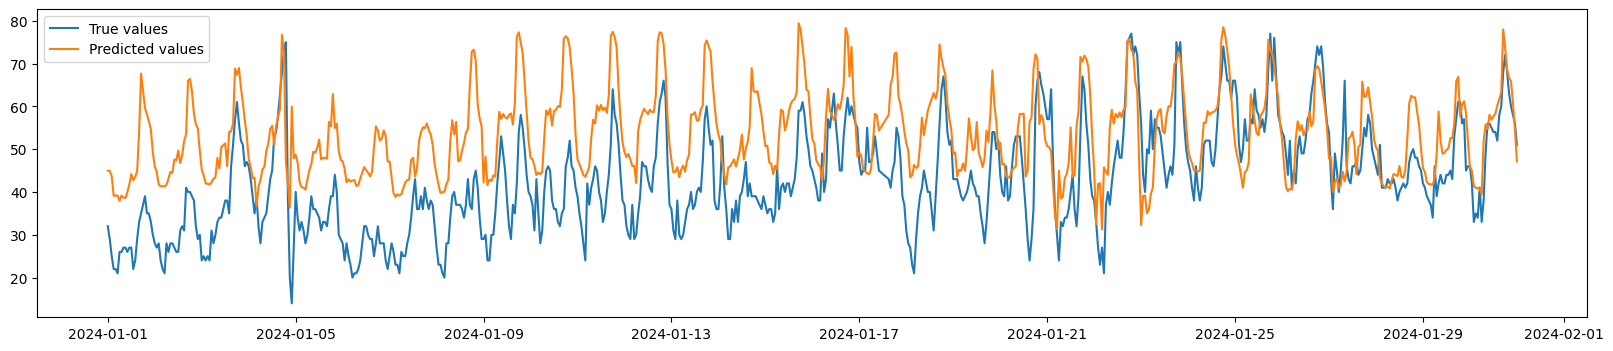

root_mean_squared_error: 18.900530735030173
r2_score: -0.776719957000005
mean_absolute_error: 15.995552701298633


In [59]:
start = datetime(2024,1,1)
end = datetime(2024,1,31)

plt.figure(figsize=figsize)
plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index>=start)&(test_sets[station][agent]['y'].index<=end)], label='True values')
plt.plot(rfr_pred_df[(rfr_pred_df.index>=start)&(rfr_pred_df.index<=end)], label='Predicted values')
plt.legend()
plt.show()

rfr_scores={}
for m in metrics:
    rfr_score = m(test_sets[station][agent]['y'],rfr_pred_df)
    print(f'{m.__name__}: {rfr_score}')
    rfr_scores[m.__name__] = rfr_score

#### **LSTM**

In [21]:
def buid_lstm_model(time_steps, n_features, optimizer='adam', loss='mean_absolute_error'):
    model = Sequential([
        LSTM(128, return_sequences=False, input_shape=(time_steps, n_features)),
        # Dropout(0.2),
        # LSTM(50, return_sequences=False),
        # Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

lstm_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

lstm_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['LSTM'] = (buid_lstm_model, lstm_params, lstm_train_params, True)

##### *Testing...*

In [61]:
station = 'PORTA SAN FELICE'
agent = 'NO2'

ts = lstm_params['time_steps']
lstm_x_train = create_sequences(training_sets[station][agent]['x'], ts)
lstm_y_train = training_sets[station][agent]['y'].iloc[ts:] # for the first `time_steps` values we don't have training samples to predict them

lstm_x_test = pd.concat([training_sets[station][agent]['x'].iloc[-ts:], test_sets[station][agent]['x']]) # to also compute the first days we need time_steps more days
lstm_x_test = create_sequences(lstm_x_test, ts)
lstm_y_test = test_sets[station][agent]['y']

In [62]:
lstm_model = buid_lstm_model(**lstm_params)
lstm_model.fit(
    lstm_x_train,
    lstm_y_train,
    **lstm_train_params
)
lstm_pred = lstm_model.predict(lstm_x_test)
lstm_pred_df = pd.DataFrame(lstm_pred, index=lstm_y_test.index)


Epoch 1/10
1342/1342 [==============================] - 6s 3ms/step - loss: 13.1620
Epoch 2/10
1342/1342 [==============================] - 4s 3ms/step - loss: 10.5698
Epoch 3/10
1342/1342 [==============================] - 4s 3ms/step - loss: 10.2715
Epoch 4/10
1342/1342 [==============================] - 4s 3ms/step - loss: 10.0607
Epoch 5/10
1342/1342 [==============================] - 4s 3ms/step - loss: 9.6385
Epoch 6/10
1342/1342 [==============================] - 4s 3ms/step - loss: 9.2317
Epoch 7/10
1342/1342 [==============================] - 4s 3ms/step - loss: 8.9892
Epoch 8/10
1342/1342 [==============================] - 4s 3ms/step - loss: 8.7659
Epoch 9/10
1342/1342 [==============================] - 4s 3ms/step - loss: 8.5924
Epoch 10/10
269/269 [==============================] - 1s 1ms/step


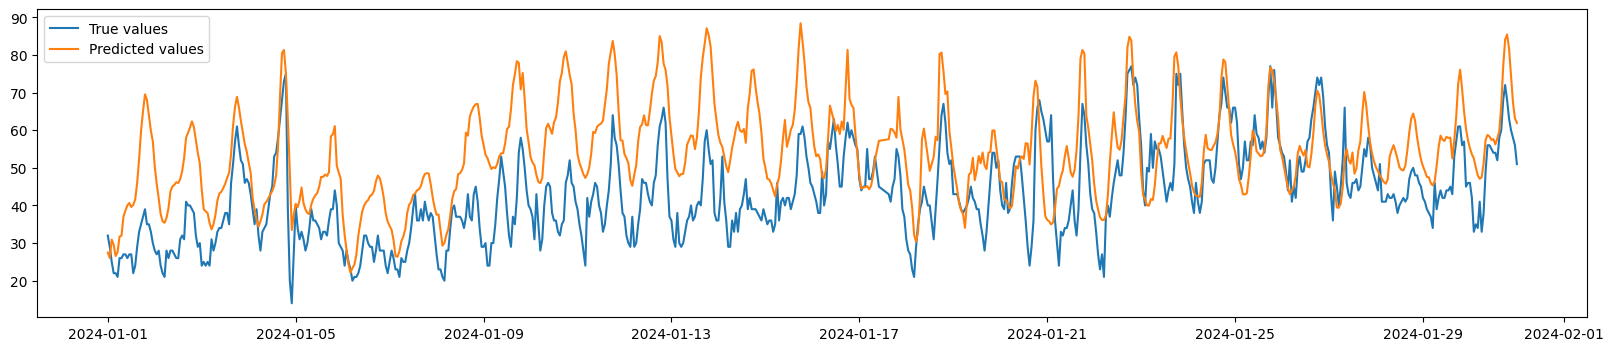

root_mean_squared_error: 19.140480593712088
r2_score: -0.8221186692654645
mean_absolute_error: 15.979563055237158


In [63]:
start = datetime(2024,1,1)
end = datetime(2024,1,31)

plt.figure(figsize=figsize)
plt.plot(lstm_y_test[(lstm_y_test.index>=start)&(lstm_y_test.index<=end)], label='True values')
plt.plot(lstm_pred_df[(lstm_pred_df.index>=start)&(lstm_pred_df.index<=end)], label='Predicted values')
plt.legend()
plt.show()

lstm_scores={}
for m in metrics:
    lstm_score = m(test_sets[station][agent]['y'],lstm_pred_df)
    print(f'{m.__name__}: {lstm_score}')
    lstm_scores[m.__name__] = lstm_score

#### **Feed Forward Neural Network**

In [22]:
def build_ffnn_model(n_features, optimizer='adam', loss='mean_absolute_error'):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=(n_features,)),
        Dropout(0.2),
        Dense(512, activation='relu'), 
        Dropout(0.2),
        Dense(256, activation='relu'),  
        Dropout(0.2),
        Dense(128, activation='relu'),  
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

ffnn_params = {
    'n_features': n_hour_features,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN'] = (build_ffnn_model, ffnn_params, ffnn_train_params, False)

##### *Testing...*

In [65]:
station = 'PORTA SAN FELICE'
agent = 'NO2'

ffnn_model = build_ffnn_model(**ffnn_params)
ffnn_model.fit(
    training_sets[station][agent]['x'], 
    training_sets[station][agent]['y'], 
    **ffnn_train_params
    )
ffnn_pred = ffnn_model.predict(test_sets[station][agent]['x'])
ffnn_pred_df = pd.DataFrame(ffnn_pred, index=test_sets[station][agent]['y'].index)

Epoch 1/10
1343/1343 [==============================] - 6s 4ms/step - loss: 11.8585
Epoch 2/10
1343/1343 [==============================] - 6s 4ms/step - loss: 11.0618
Epoch 3/10
1343/1343 [==============================] - 6s 4ms/step - loss: 10.8341
Epoch 4/10
1343/1343 [==============================] - 6s 4ms/step - loss: 10.6086
Epoch 5/10
1343/1343 [==============================] - 6s 4ms/step - loss: 10.4301
Epoch 6/10
1343/1343 [==============================] - 6s 4ms/step - loss: 10.4202
Epoch 7/10
1343/1343 [==============================] - 6s 4ms/step - loss: 10.2598
Epoch 8/10
1343/1343 [==============================] - 6s 4ms/step - loss: 10.2188
Epoch 9/10
1343/1343 [==============================] - 6s 4ms/step - loss: 10.2301
Epoch 10/10
269/269 [==============================] - 0s 1ms/step


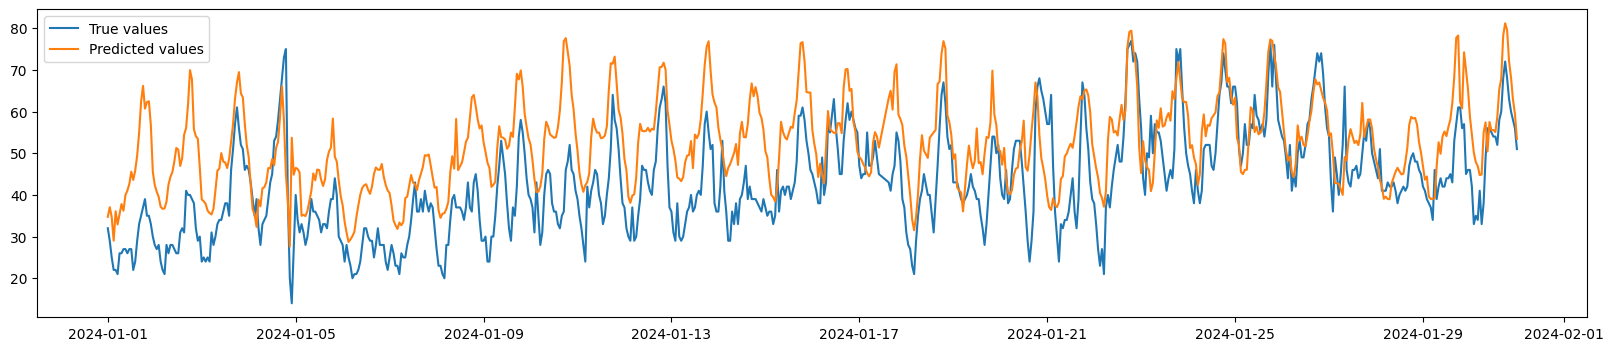

root_mean_squared_error: 19.086639123420603
r2_score: -0.8118819812090998
mean_absolute_error: 15.907170569684395


In [66]:
start = datetime(2024,1,1)
end = datetime(2024,1,31)

plt.figure(figsize=figsize)
plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index>=start)&(test_sets[station][agent]['y'].index<=end)], label='True values')
plt.plot(ffnn_pred_df[(ffnn_pred_df.index>=start)&(ffnn_pred_df.index<=end)], label='Predicted values')
plt.legend()
plt.show()

ffnn_scores={}
for m in metrics:
    ffnn_score = m(test_sets[station][agent]['y'],ffnn_pred_df)
    print(f'{m.__name__}: {ffnn_score}')
    ffnn_scores[m.__name__] = ffnn_score

#### **XGBoost**

In [30]:
xgbr_params = {
    'objective': "reg:squarederror",
    'n_estimators': 100,
    # 'max_depth': 20
}

hour_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

##### *Testing...*

In [31]:
agent = 'PORTA SAN FELICE'
agent = 'NO2'

xgbr_model = xgb.XGBRegressor(**xgbr_params)
xgbr_model.fit(training_sets[station][agent]['x'], training_sets[station][agent]['y'])
xgbr_pred = xgbr_model.predict(test_sets[station][agent]['x'])
xgbr_pred_df = pd.DataFrame(xgbr_pred, index=test_sets[station][agent]['y'].index)

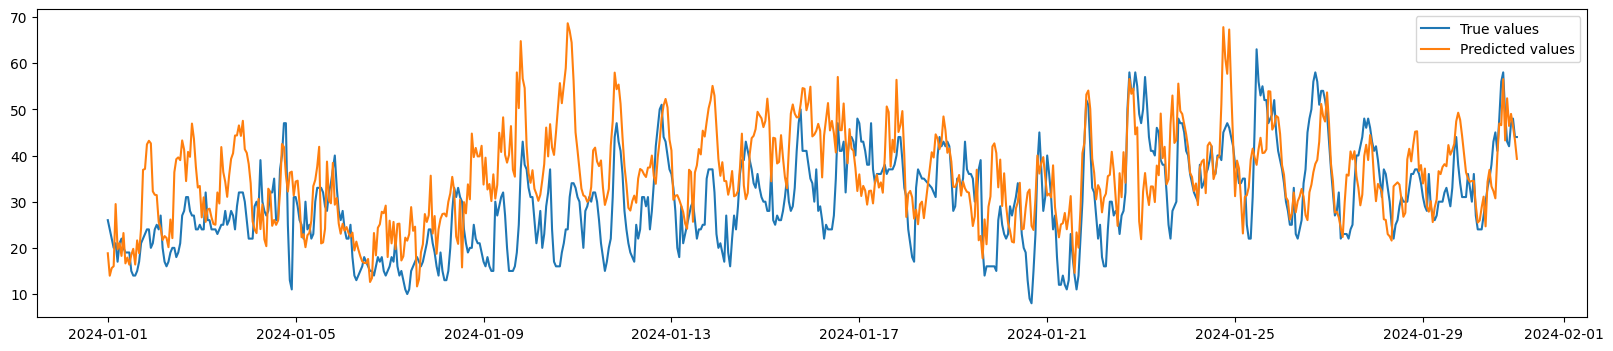

root_mean_squared_error: 8.510071965124986
r2_score: 0.3405075443667299
mean_absolute_error: 6.351526721612011
mean_absolute_percentage_error: 187725041127808.9


In [32]:
start = datetime(2024,1,1)
end = datetime(2024,1,31)

plt.figure(figsize=figsize)
plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index>=start)&(test_sets[station][agent]['y'].index<=end)], label='True values')
plt.plot(xgbr_pred_df[(xgbr_pred_df.index>=start)&(xgbr_pred_df.index<=end)], label='Predicted values')
plt.legend()
plt.show()

xgbr_scores={}
for m in metrics:
    xgbr_score = m(test_sets[station][agent]['y'],xgbr_pred_df)
    print(f'{m.__name__}: {xgbr_score}')
    xgbr_scores[m.__name__] = xgbr_score

#### **Test comparisons**

Assuming that the predictions are on the same station and agent.

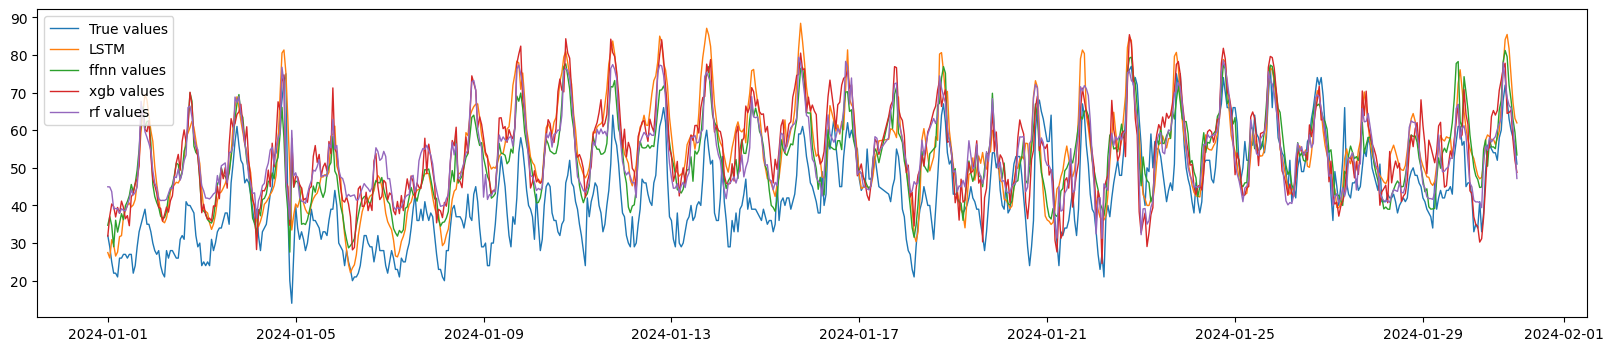

root_mean_squared_error:
 - LSTM: 19.140480593712088
 - FFNN: 19.086639123420603
 - XGB: 19.131036983120506
 - RF: 18.900530735030173
r2_score:
 - LSTM: -0.8221186692654645
 - FFNN: -0.8118819812090998
 - XGB: -0.8203211037178786
 - RF: -0.776719957000005
mean_absolute_error:
 - LSTM: 15.979563055237158
 - FFNN: 15.907170569684395
 - XGB: 16.03929758873936
 - RF: 15.995552701298633


In [70]:
start = datetime(2024,1,1)
end = datetime(2024,1,31)

plt.figure(figsize=figsize)
plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index>=start)&(test_sets[station][agent]['y'].index<=end)], label='True values', linewidth=1)
plt.plot(lstm_pred_df[(lstm_pred_df.index>=start)&(lstm_pred_df.index<=end)], label='LSTM', linewidth=1)
plt.plot(ffnn_pred_df[(ffnn_pred_df.index>=start)&(ffnn_pred_df.index<=end)], label='ffnn values', linewidth=1)
plt.plot(xgbr_pred_df[(xgbr_pred_df.index>=start)&(xgbr_pred_df.index<=end)], label='xgb values', linewidth=1)
plt.plot(rfr_pred_df[(rfr_pred_df.index>=start)&(rfr_pred_df.index<=end)], label='rf values', linewidth=1)
# plt.xlim(test_sets[station][agent]['y'].index[0],test_sets[station][agent]['y'].index[-1])
plt.legend()
plt.show()

for m in metrics:
    name = m.__name__
    print(f'{name}:')
    print(f' - LSTM: {lstm_scores[name]}')
    print(f' - FFNN: {ffnn_scores[name]}')
    print(f' - XGB: {xgbr_scores[name]}')
    print(f' - RF: {rfr_scores[name]}')

ziocane ffnn ha gli errori più bassi di tutti ma fa merda

## **Daily agents**

In [6]:
daily_models = {} # contains tuples: (ModelClass, model_params:dict, training_params:dict, sequences:bool|dict)

### **Models**

**NOTE:** For now, I simply copied the one above

#### **Random Forest Regressor**

In [7]:
rfr_params = {
    'n_estimators':100,
    'max_depth':10
}

daily_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

#### **XGBoost Regressor**

In [8]:
xgbr_params = {
    'objective': "reg:squarederror",
    'n_estimators': 100,
    # 'max_depth': 20
}

daily_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

#### **LSTM**

In [12]:
def buid_lstm_model(time_steps, n_features, optimizer='adam', loss='mean_absolute_error'):
    model = Sequential([
        LSTM(128, return_sequences=False, input_shape=(time_steps, n_features)),
        # Dropout(0.2),
        # LSTM(50, return_sequences=False),
        # Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

lstm_params = {
    'time_steps': 1, #NOTE is set to 1 cause no causality
    'n_features': n_daily_features,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

lstm_train_params = {
    'epochs':10,
    'batch_size':32,
}

daily_models['LSTM'] = (buid_lstm_model, lstm_params, lstm_train_params, True)

In [13]:
lstm_params_huber = {
    'time_steps': 1, #NOTE is set to 1 cause no causality
    'n_features': n_daily_features,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': tf.keras.losses.Huber(delta=0.2)
}

daily_models['LSTM-huber'] = (buid_lstm_model, lstm_params_huber, lstm_train_params, True)

#### FFNN

In [14]:
def build_ffnn_model(n_features, optimizer='adam', loss='mean_absolute_error'):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=(n_features,)),
        Dropout(0.2),
        Dense(512, activation='relu'), 
        Dropout(0.2),
        Dense(256, activation='relu'),  
        Dropout(0.2),
        Dense(128, activation='relu'),  
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

ffnn_params = {
    'n_features': n_daily_features,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn_train_params = {
    'epochs':10,
    'batch_size':32,
}

daily_models['Feed Forward NN'] = (build_ffnn_model, ffnn_params, ffnn_train_params, False)

In [15]:
ffnn_params_huber = {
    'n_features': n_daily_features,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': tf.keras.losses.Huber(delta=0.2)
}


daily_models['Feed Forward NN-huber'] = (build_ffnn_model, ffnn_params_huber, ffnn_train_params, False)

## **Agents Evaluations**

### Hour Models

In [ ]:
hour_results = train_models(
    hour_models,training_sets,test_sets,metrics,
    to_execute={
        'agents':'all',
        'stations':'all',
        'models':'all',
    },
    ignore={
        'stations':[],
        'agents':['PM10','PM2.5'],
        'models':[]
        },
    v=1
)

In [ ]:
hour_extracted_data = extract_data(hour_results)
hour_extracted_data.sort_values(by=[])
# we could also print with some groupby to order each model etc

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,mean_squared_error
0,GIARDINI MARGHERITA,O3,Random Forest Regressor,14.357239,0.838404,10.908156,206.130309
1,GIARDINI MARGHERITA,O3,LSTM,13.707449,0.852700,10.203945,187.894165
2,GIARDINI MARGHERITA,O3,Feed Forward NN,19.865540,0.690621,15.173344,394.639684
3,GIARDINI MARGHERITA,O3,XGB Regressor,14.529542,0.834502,10.980940,211.107599
4,GIARDINI MARGHERITA,NO2,Random Forest Regressor,7.814487,0.453443,5.741921,61.066200
5,GIARDINI MARGHERITA,NO2,LSTM,7.858097,0.447325,5.498109,61.749687
6,GIARDINI MARGHERITA,NO2,Feed Forward NN,6.944816,0.568326,4.749038,48.230467
7,GIARDINI MARGHERITA,NO2,XGB Regressor,7.693566,0.470227,5.591722,59.190959
8,PORTA SAN FELICE,C6H6,Random Forest Regressor,0.463710,0.565636,0.285924,0.215027
9,PORTA SAN FELICE,C6H6,LSTM,0.411006,0.658763,0.258848,0.168926


##### **EXAMPLE:** how to eventually try new metrics

In [ ]:
from sklearn.metrics import mean_squared_error

metrics.append(mean_squared_error) # even if you append multiple times, the result is written on a dict so there are no duplicates. Anyways, be careful :)

In [143]:
new_hour_results = update_metrics(hour_results, test_sets, metrics)
new_hour_extracted_data = extract_data(new_hour_results)
new_hour_extracted_data.sort_values(by=['Agent','Model','Station'])

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,mean_squared_error
1,GIARDINI MARGHERITA,NO2,XGB Regressor,7.693566,0.470227,5.591722,59.190959
3,VIA CHIARINI,NO2,XGB Regressor,8.510072,0.340508,6.351527,72.421325
0,GIARDINI MARGHERITA,O3,XGB Regressor,14.529542,0.834502,10.980940,211.107599
2,VIA CHIARINI,O3,XGB Regressor,14.504967,0.836600,10.876629,210.394056


### Daily Models

In [28]:
daily_results = train_models(
    daily_models,training_sets,test_sets,metrics,
    to_execute={
        'agents':['PM10','PM2.5'],
        'stations':'all',
        'models':'all',
        },
    ignore={
        'stations':[],
        'agents':[],
        'models':[]
        },
    v=0
)

Train settings:
stations: ['GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'VIA CHIARINI']
agents: ['PM10', 'PM2.5']
models: ['Random Forest Regressor', 'XGB Regressor', 'Feed Forward NN', 'LSTM', 'LSTM-huber', 'Feed Forward NN-huber']


In [29]:
updated_daily_results = update_metrics(daily_results, test_sets, []) # an empty list simply wont add metrics
daily_extracted_data = extract_data(updated_daily_results)
daily_extracted_data.sort_values(by=['Agent','Model','Station'])

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,mean_absolute_percentage_error
2,GIARDINI MARGHERITA,PM10,Feed Forward NN,10.564888,0.399784,7.380251,5.001103e-01
14,PORTA SAN FELICE,PM10,Feed Forward NN,11.402153,0.451028,7.313866,3.170909e-01
26,VIA CHIARINI,PM10,Feed Forward NN,11.279299,0.331173,8.410831,2.736184e+14
5,GIARDINI MARGHERITA,PM10,Feed Forward NN-huber,10.497102,0.407462,7.347249,5.210176e-01
17,PORTA SAN FELICE,PM10,Feed Forward NN-huber,12.435783,0.346986,8.059573,3.187356e-01
29,VIA CHIARINI,PM10,Feed Forward NN-huber,11.344625,0.323403,7.670497,2.273645e+14
3,GIARDINI MARGHERITA,PM10,LSTM,10.363877,0.422407,7.285825,5.565046e-01
15,PORTA SAN FELICE,PM10,LSTM,11.837998,0.408258,7.707580,3.579165e-01
27,VIA CHIARINI,PM10,LSTM,11.091087,0.353308,8.024098,1.401207e+14
4,GIARDINI MARGHERITA,PM10,LSTM-huber,10.495706,0.407619,7.238470,5.268324e-01
